In [1]:
import torch
from torch.utils.data import Dataset
from torch import nn, einsum, Tensor
from denoising_diffusion_pytorch import Trainer1D, Unet1D, GaussianDiffusion1D
from load_dataset import get_input_seqs_dataloader
import joblib
import numpy as np
from Architectures.decoder_conv import Decoder
from Architectures.encoder_conv import Encoder
from Architectures.autoencoder_conv_pl import Autoencoder
from torchview import draw_graph
import graphviz

c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


class Unet1D(nn.Module):
        dim : factor used with dim_mults to make the subsequent dimensions,
        init_dim : first dimension. no impact on 'dim',
        out_dim : ?? 1 by default, 2 if learned_variance = true,
        dim_mults: dimensions muplicator of 'dim',
        channels : 1,
        self_condition = False,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16
    ):

In [2]:
train, test = get_input_seqs_dataloader('data/latent_dim.joblib',shuffle=False, train_size=1, batch_size=256)

In [31]:
model = Unet1D(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 1,

)

In [32]:
diffusion = GaussianDiffusion1D(
    model,
    seq_length = 1024,
    timesteps = 1000,
    objective = 'pred_v'
)

In [4]:
t = joblib.load('data/latent_dim.joblib')

In [8]:
class Dataset1D(Dataset):
    def __init__(self, tensor: Tensor):
        super().__init__()
        self.tensor = tensor.clone()

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, idx):
        return self.tensor[idx].clone()


(dot.exe:26784): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


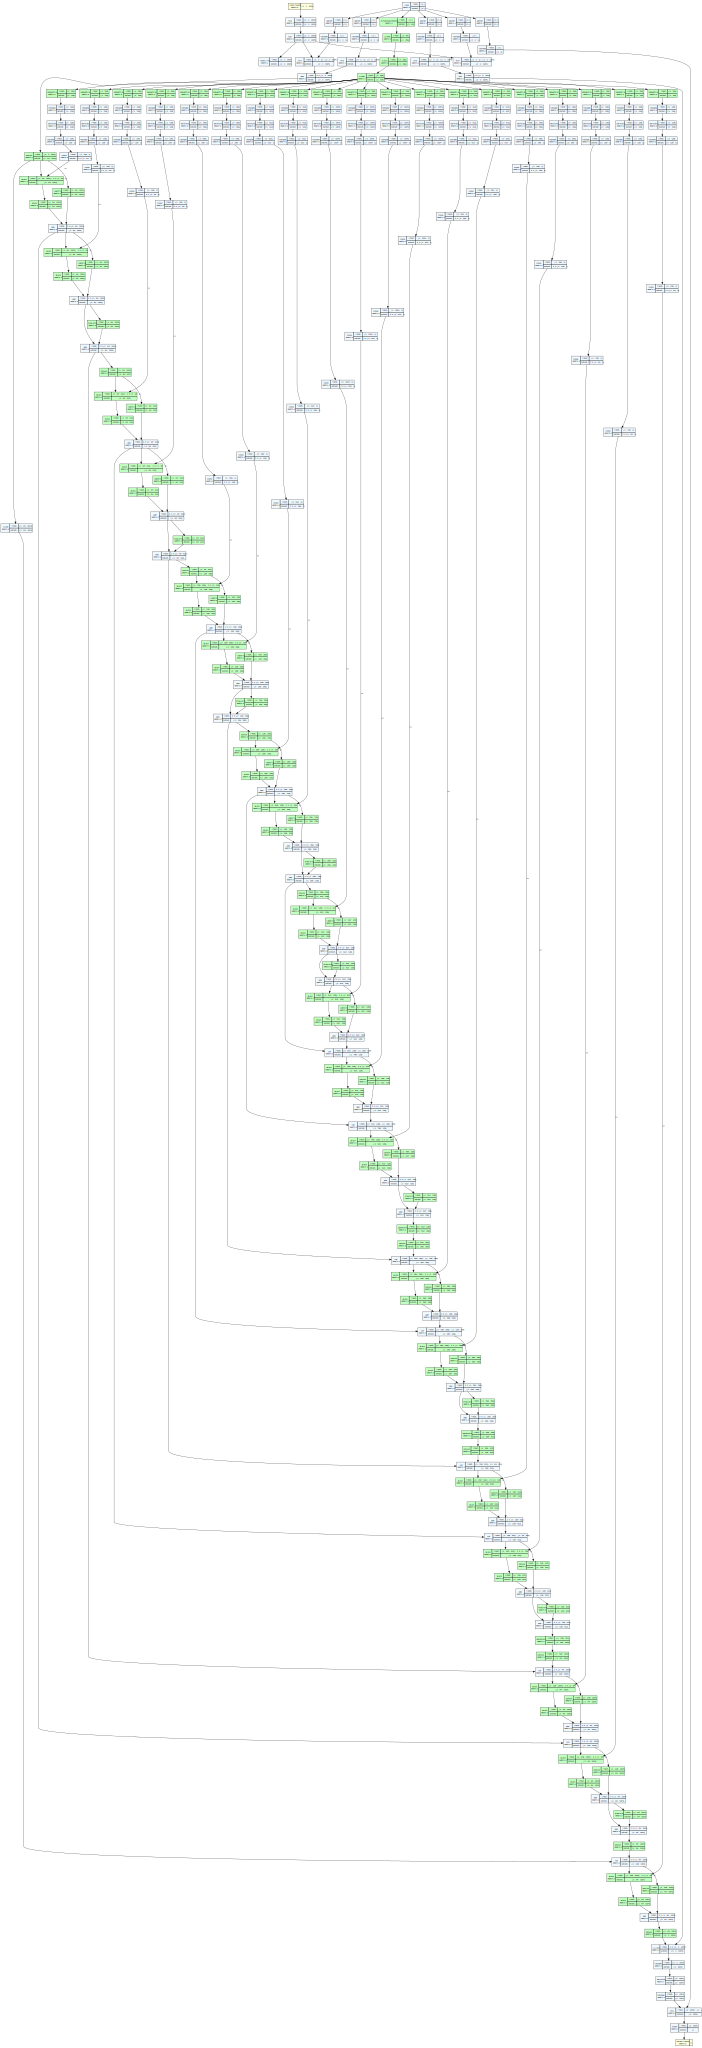

In [69]:
draw_graph(diffusion, input_size=(1,1,1024)).visual_graph


In [9]:
dataset_train = Dataset1D(t['inputs'].detach()[:100])

In [16]:
trainer = Trainer1D(
    diffusion,
    dataset = dataset_train,
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 100000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
)


In [17]:
import glob
import os
import re

list_of_files = glob.glob('results/*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
pattern = r"(\d+)"
match = re.search(pattern, latest_file)
if match:
    result = match.group(1)
    print(result, type(result))

results\model-100.pt
100 <class 'str'>


In [18]:
trainer.load(result)

loading from version 1.8.3


In [32]:
trainer.train()


 37%|███▋      | 37000/100000 [00:04<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\Jean-Luc\AppData\Local\Temp\ipykernel_21960\49973641.py:1 in <module>                   │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\Jean-Luc\\AppData\\Local\\Temp\\ipykernel_21960\\49973641.py'                        │
│                                                                                                  │
│ c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\denoising_diffusion_pytorch\deno │
│ ising_diffusion_pytorch_1d.py:859 in train                                                       │
│                                                                                                  │
│   856 │   │   │   │   │   │   loss = loss / self.gradient_accumulate_every                       │
│   857 │   │   │   │   │   │   total_loss += loss.item()                                          │
│   858 │   │   │   │   │                                                                          │
│ ❱ 859 │   │   │   │   │   self.accelerator.backward(loss)                                        │
│   860 │   │   │   │                                                                              │
│   861 │   │   │   │   accelerator.clip_grad_norm_(self.model.parameters(), 1.0)                  │
│   862 │   │   │   │   pbar.set_description(f'loss: {total_loss:.4f}')                            │
│                                                                                                  │
│ c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\accelerate\accelerator.py:1745   │
│ in backward                                                                                      │
│                                                                                                  │
│   1742 │   │   elif self.scaler is not None:                                                     │
│   1743 │   │   │   self.scaler.scale(loss).backward(**kwargs)                                    │
│   1744 │   │   else:                                                                             │
│ ❱ 1745 │   │   │   loss.backward(**kwargs)                                                       │
│   1746 │                                                                                         │
│   1747 │   def unscale_gradients(self, optimizer=None):                                          │
│   1748 │   │   """                                                                               │
│                                                                                                  │
│ c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\torch\_tensor.py:487 in backward │
│                                                                                                  │
│    484 │   │   │   │   create_graph=create_graph,                                                │
│    485 │   │   │   │   inputs=inputs,                                                            │
│    486 │   │   │   )                                                                             │
│ ❱  487 │   │   torch.autograd.backward(                                                          │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    489 │   │   )                                                                                 │
│    490                                                                                           │
│                                                                                                  │
│ c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\torch\autograd\__init__.py:193   │
│ in backward                                                

In [33]:
sampled_seq = diffusion.to(torch.device('cuda')).sample(batch_size = 4)
sampled_seq.shape 

sampling loop time step: 100%|██████████| 1000/1000 [00:50<00:00, 19.90it/s]


torch.Size([4, 1, 1024])

In [20]:
autoencoder = joblib.load('[1965, 512, 256]_1024_Tanh_AdamW_MSELoss_0_False_4_1_1')

In [21]:
decoder = autoencoder.decoder

In [34]:
mat = decoder(sampled_seq.detach().cpu())

torch.Size([4, 1, 1024])
torch.Size([4, 1, 5120])
torch.Size([4, 256, 20])
torch.Size([4, 1965, 22])


In [23]:
mat.shape

torch.Size([4, 1965, 22])

In [24]:
from utils import reconstruct_sequence
rand_mat = joblib.load('data/AA_random_matrices_orth.joblib')

In [35]:
[''.join(x) for x in reconstruct_sequence(rand_mat, mat.detach().cpu())]

['TAISIKCCKGGATKCAANGGCGEAGCAAKKVVCLKGDCGCACIMCDIIGCMKCICGGGCIGGGMICIIMGICIGCMCGGICEIEEAMCECRCCMECECEMIKMMCECGGC_CCLMCMAGRMYKMRSCCMSQMQRTFRLKYMQRYYEMYKYSCQYLEFDYSCYAR_DYSEEYDYFDCEEDE_CEARAPYAAD__L_EY__EKVA__F_YEIA_DD_____AL___________I________________F_____AN_A__Q____HN______ADN__AH_________NTN_H_A_A__N_NAA__NTAHHNHH_QA_H_HTQ_HMHQTT___AN_GTT________T______Q_L___M_MME____G_M_M_GNMGGE_GEGLMVIQVMGGGGG_TMGLGMGEIXCMMTM_LEEXEYD_GGEEMG_METMDDMGMMMLGTLEGITEMEEGGP_GGXDXIMQQCDDGIQCMGGM_KGMLDEIIFSEMMXGERIEIDMMGIIGDGREDXPMETLTEGIEREHIL_GGQIMG_AELGLEAEDGGEDMMIQMKIEMREE_ILEDEKGDEDGTQ_EPMCVEIDDEGMTKDMRT_SIRGALXYI_E_MM_MIL_XGVIXYMXKIIDKEEMDENLSLYEETRXTLDKRIEKPNI_ITIYNQMKXTEILXM_DGTMMAAGDNEKIEELNM_IRRADPLEEDNX__XPNIEMHYEI_IM_EKELDIE__VKG_X_D_HM_D_EI_DS__NGEEHI_EEIXNHHDE_KFGIN_NXEI_IKIHXPFDF_VGXAIILXN__A_IDEI_EE__IDDADI__M_EAGX__DXMI__YEM_MFHA_P_N___DKE__A_X_D_AXM__Q_DMDXKV_INVD_M__VP_IM_X_MX_QA_MDN_A_E__M__GD_XA_G__XN_K_A_MLM_X_M_DTAS_E__HM___E__V__N_YS_M___A_HN_A_____X_VS__D______E_L__IXMA_I__APDL_M_V

In [1]:
from einops import rearrange
import joblib
import torch

In [2]:

data = joblib.load('data/AA_orth.joblib')

In [5]:
data['inputs'][:,:1960,:].shape

torch.Size([43493, 1960, 22])